In [1]:
import pandas as pd

In [64]:
import pickle

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [57]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error

In [47]:
def read_datafram(filename):
    df = pd.read_parquet(filename)
    
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    df["duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60 )
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    categorical = ["PULocationID" , "DOLocationID"]
    
    df[categorical] = df[categorical].astype(str)
    return df

In [48]:
df_train = read_datafram("./data/green_tripdata_2022-01.parquet")
df_val = read_datafram("./data/green_tripdata_2022-02.parquet")

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

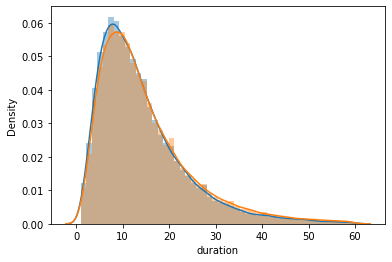

In [49]:
sns.distplot(df_train.duration, label = "train_duration")
sns.distplot(df_val.duration, label = "val_duration")

In [50]:
train_dicts = df_train[["PULocationID" , "DOLocationID"] + ["trip_distance"]].to_dict(orient = "records")
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
target = "duration"
y_train = df[target].values
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_train)
mean_squared_error(y_train, y_pred, squared = False)

7.652716560267797

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


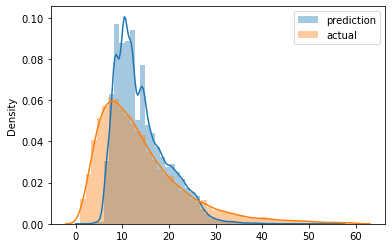

In [51]:
sns.distplot(y_pred, label = "prediction")
sns.distplot(y_train, label = "actual")
plt.legend()

In [60]:
df_train["PU_DO"] = df_train["PULocationID"] + "_" + df_train["DOLocationID"]
df_val["PU_DO"] = df_val["PULocationID"] + "_" + df_val["DOLocationID"]

In [61]:
categorical = ["PU_DO"]#"PULocationID" , "DOLocationID"]
numerical = ["trip_distance"]

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient = "records")
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient = "records")
X_val= dv.transform(val_dicts)

In [62]:
target = "duration"

y_train = df_train[target].values
y_val = df_val[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)


y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared = False)

6.771091643673534

In [65]:
with open("models/lin_reg.bin" , "wb") as f_out:
    pickle.dump((dv, lr), f_out)

In [63]:
lr = Lasso()
lr.fit(X_train, y_train)


y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared = False)

9.987740663463478